In [35]:
import awkward as ak
import numpy as np
import pickle as pkl
import hist 
import matplotlib.pyplot as plt
import uproot

import os
from numba import njit

import mplhep as hep

In [15]:
hep.style.use('CMS')

In [2]:
import secrets
secrets.randbits(128)

236860161341377533497318985914273181444

In [3]:
seed = 157787644118040162645699200457491913582
parent_rng = np.random.default_rng(seed)
child_rngs = parent_rng.spawn(4)
print(child_rngs)

[Generator(PCG64) at 0x1504ED540, Generator(PCG64) at 0x1504ED460, Generator(PCG64) at 0x1504ED380, Generator(PCG64) at 0x1504ED9A0]


In [4]:
uniform = [parent_rng.random() for _ in range(10000)]
front = uniform[:5000]
back = uniform[5000:]

delta_hist = hist.Hist(hist.axis.Regular(30, 0, 30, name='deltas'))

delta = []
for f in front:
    for b in back:
        delta.append(f-b)
        delta_hist.fill(f-b)

In [24]:
for rng in child_rngs:
    print([rng.integers(1, 10, dtype=int) for _ in range(11)])

[3, 5, 8, 7, 1, 6, 2, 5, 1, 6, 9]
[4, 9, 2, 7, 3, 9, 9, 4, 6, 8, 1]
[2, 4, 6, 7, 1, 8, 2, 1, 6, 4, 6]
[2, 7, 6, 8, 4, 7, 2, 4, 6, 2, 2]


In [25]:
seed = 157787644118040162645699200457491913582
ss = np.random.SeedSequence(seed)
child_seeds = ss.spawn(4)
child_seeds

[SeedSequence(
     entropy=157787644118040162645699200457491913582,
     spawn_key=(0,),
 ),
 SeedSequence(
     entropy=157787644118040162645699200457491913582,
     spawn_key=(1,),
 ),
 SeedSequence(
     entropy=157787644118040162645699200457491913582,
     spawn_key=(2,),
 ),
 SeedSequence(
     entropy=157787644118040162645699200457491913582,
     spawn_key=(3,),
 )]

In [26]:
streams = [np.random.default_rng(s) for s in child_seeds]
streams

[Generator(PCG64) at 0x138BF91C0,
 Generator(PCG64) at 0x138BF97E0,
 Generator(PCG64) at 0x138BF98C0,
 Generator(PCG64) at 0x13FA5EF80]

In [27]:
for rng in streams:
    print([rng.integers(1, 10, dtype=int) for _ in range(11)])

[3, 5, 8, 7, 1, 6, 2, 5, 1, 6, 9]
[4, 9, 2, 7, 3, 9, 9, 4, 6, 8, 1]
[2, 4, 6, 7, 1, 8, 2, 1, 6, 4, 6]
[2, 7, 6, 8, 4, 7, 2, 4, 6, 2, 2]


Ultimate goal: implement multiprocessing for analyzing data. 

Structure: have a main function that does analysis, creating histograms and counting Z's. I can then have a separate process for each run of the event generator, which in principle will give me a 4x speed-up. 

For each run, I will need to process the data in batches. This should be fine so long as we aren't doing any mixed event corrections, which we aren't yet. Those would need a separate implementation.

In [38]:

def process_events(parent_data_dir, run_num):
    pt_all_hist = hist.Hist(hist.axis.Regular(30, 0, 30, name='pt all'))
    
    Z_counter = 0
    W_counter = 0

    events_w_Z = ak.Array([])
    
    run_data_dir = parent_data_dir + f'run{run_num}/' 
    for file in os.listdir(run_data_dir):
        
        with open(run_data_dir + file, 'rb') as in_file:
            events = pkl.load(in_file)
            
            z_counts = np.sum(events['pdg'] == 23)
            W_counts = np.sum(events['pdg'] == abs(24))
            
            pt_all_hist.fill(np.sqrt(ak.flatten(events['px'])**2 + ak.flatten(events['py'])**2))
            
            if z_counts > 0:
                
                contains_Z = ak.any(events['pdg']==23, axis=1)
                events_w_Z = ak.concatenate([events_w_Z, events[contains_Z]])
                
            
            Z_counter += z_counts
            W_counter += W_counts
            
    print(Z_counter, W_counter)
    
    return pt_all_hist, events_w_Z

In [18]:
RAW_DATA_DIR = '/Users/ravikoka/repos/z_plus_hf/feasibility/data/multi/'
pt_all_hist, events_w_Z = process_events(RAW_DATA_DIR, 0)

0 0


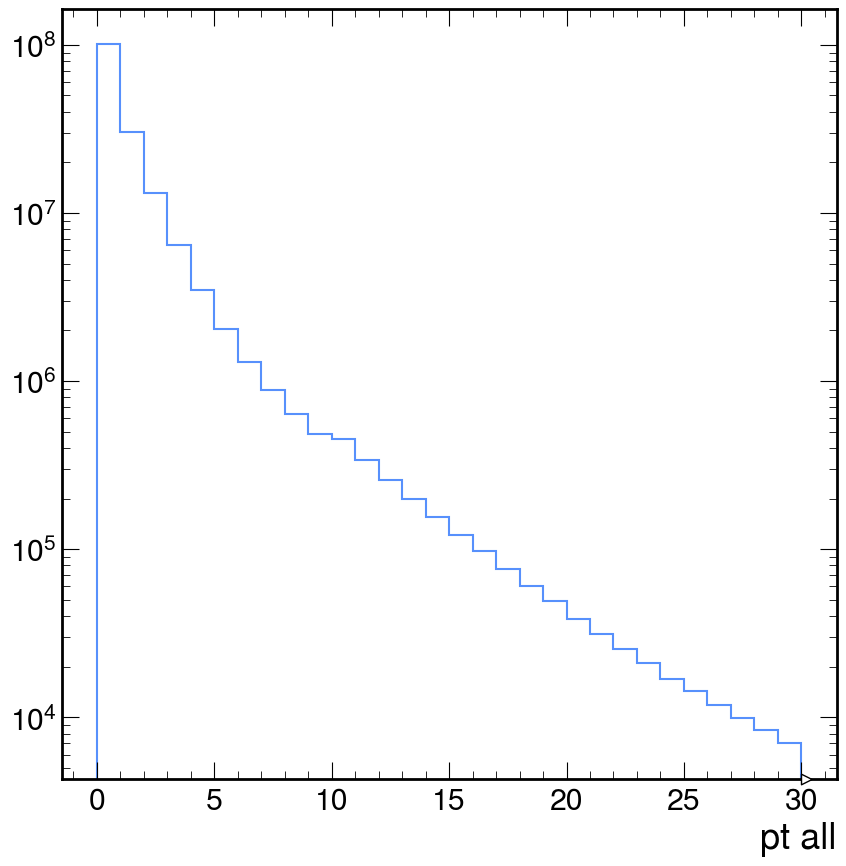

In [24]:
fig, ax = plt.subplots()
hep.histplot(pt_all_hist, yerr=True, ax=ax)

ax.set_yscale('log')

In [9]:
events_w_Z

<Array [{px: [0, ...], py: [...], ...}, ...] type='3 * {px: var * float64, ...'>

In [36]:
Z_bosons = events_w_Z[events_w_Z['pdg'] == 23]
pt_Z_bosons = hist.Hist(hist.axis.Regular(30, 0, 30, name='pt Z0'))

for event in Z_bosons:
    #px, py, pz = event['px'][0], event['py'][0], event['pz'][0]
    for px, py, pz in zip(event['px'], event['py'], event['pz']):
        print(px**2 + py**2 + pz**2)
    print('----------------')
    
    print(px, py, pz)

129221.4420587132
130655.69813089291
----------------
1.06049346490429 -0.04849593416401438 361.46171461532157
1023841.0265611301
1104661.2566337697
1105122.9048954155
1105934.565127867
----------------
12.216433573441407 31.328476296465343 -1051.096499114879
256815.06637800534
232776.2110104718
237666.6701282392
238144.3372116737
235438.89596004307
235377.18984996693
----------------
17.400452965986837 45.66422483340056 -482.68954065414556


In [42]:
RAW_DATA_DIR = '/Users/ravikoka/repos/z_plus_hf/feasibility/data/multi/'
p1, z1 = process_events(RAW_DATA_DIR, 0)
p2, z2 = process_events(RAW_DATA_DIR, 1)
p3, z3 = process_events(RAW_DATA_DIR, 2)
p4, z4 = process_events(RAW_DATA_DIR, 3)

7 0
0 0
6 0
0 0
